Improve the readability of the text-
This file contains graphs for interpretability which are also important to resolve the following issue:

    Lack of Model Comparison:
   - The code does not compare the performance of the individual base models (XGBoost and Naive Bayes) to the combined model.
   - It would be helpful to understand the relative contribution of each base model and whether the ensemble approach actually provides a significant performance improvement over the individual models.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import numpy as np
import joblib

In [2]:
data = pd.read_csv(r'C:\Users\vidha\Downloads\normalized_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31118 entries, 0 to 31117
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   comment_score       31118 non-null  float64
 1   controversiality    31118 non-null  float64
 2   user_is_verified    31118 non-null  float64
 3   user_awardee_karma  31118 non-null  float64
 4   user_awarder_karma  31118 non-null  float64
 5   user_total_karma    31118 non-null  float64
 6   post_score          31118 non-null  float64
 7   post_upvote_ratio   31118 non-null  float64
 8   total_comments      31118 non-null  float64
 9   first_topic_title   0 non-null      float64
 10  sentiment_score     31118 non-null  float64
 11  subreddit_encoded   31118 non-null  float64
 12  top_topics_encoded  31118 non-null  float64
 13  top_words_per_doc   31118 non-null  object 
 14  combined_text       31118 non-null  object 
 15  top_topics          31118 non-null  object 
 16  toke

In [3]:
df=pd.DataFrame(data)
display(df.head(10))

,comment_score,controversiality,user_is_verified,user_awardee_karma,user_awarder_karma,user_total_karma,post_score,post_upvote_ratio,total_comments,first_topic_title,sentiment_score,subreddit_encoded,top_topics_encoded,top_words_per_doc,combined_text,top_topics,tokens
0,0.024446,0.0,1.0,0.000094,0.001078,0.001120,0.014727,0.989247,0.243553,NaN,0.657131,0.886364,0.333333,"['daybrutal', 'repli', 'krynki', 'elimin', 'de...",brutal elimin russian soldier krynki drone dro...,1.0,"['brutal', 'elimin', 'russian', 'soldier', 'kr..."
1,0.025757,0.0,1.0,0.000000,0.000000,0.000264,0.118739,0.956989,0.667622,NaN,0.289393,0.909091,0.000000,"['stupidwe', 'budget', '50', 'singl', '10', 'd...",we spend 10 defen budget destroy 50 russian we...,0.0,"['we', 'spend', '10', 'defen', 'budget', 'dest..."
2,0.024326,1.0,0.0,0.000000,0.000000,0.000008,0.004353,0.838710,0.226361,NaN,0.540277,0.795455,0.333333,"['advanc', 'soborna', 'vulytsya', 'p07', 'cont...",ru pov russian continu advanc along vulytsya s...,1.0,"['ru', 'pov', 'russian', 'continu', 'advanc', ..."
3,0.024207,1.0,1.0,0.004631,0.000421,0.011631,0.004145,0.946237,0.085960,NaN,0.553706,0.409091,0.000000,"['korea', 'republputin', 'north', 'allegi', 'm...",putin announc run presid 2024 song trend north...,0.0,"['putin', 'announc', 'run', 'presid', '2024', ..."
4,0.024326,0.0,1.0,0.002072,0.000000,0.002853,0.000093,0.817204,0.022923,NaN,0.534590,0.022727,0.000000,"['alaska', 'alaskarussian', 'hawaii', 'idealis...",russian learn think colon alaska expedit hawai...,0.0,"['russian', 'learn', 'think', 'colon', 'alaska..."
5,0.024207,1.0,1.0,0.000623,0.000000,0.001891,0.053326,0.989247,0.229226,NaN,0.640816,0.659091,0.333333,"['adaptchang', 'tarantul', 'surerussian', 'cor...",russian tarantul corvett sink occupi sevastopo...,1.0,"['russian', 'tarantul', 'corvett', 'sink', 'oc..."
6,0.024207,1.0,1.0,0.000000,0.000000,0.000099,0.235626,0.838710,0.845272,NaN,0.443790,0.181818,1.000000,"['forgetanoth', 'infant', 'highris', '7th', 'c...",anoth crime human russian feder last night rus...,missing,"['anoth', 'crime', 'human', 'russian', 'feder'..."
7,0.024803,0.0,1.0,0.001369,0.000000,0.004755,0.038067,0.946237,0.309456,NaN,0.529702,1.000000,0.000000,"['internetlose', 'bu', 'quick', 'gtthe', 'hear...",lose heart nato chief tell ukrain alli gtthe t...,0.0,"['lose', 'heart', 'nato', 'chief', 'tell', 'uk..."
8,0.024207,0.0,1.0,0.001045,0.064945,0.003946,0.046935,0.956989,0.567335,NaN,0.583969,0.909091,0.333333,"['huntukrainian', 'godspe', 'power', 'pul', 'c...",ukrainian build first cruis missil power weapo...,1.0,"['ukrainian', 'build', 'first', 'cruis', 'miss..."
9,0.024446,1.0,1.0,0.000000,0.000000,0.000109,0.000069,0.483871,0.005731,NaN,0.510099,0.795455,0.333333,"['childrag', 'musicua', 'okhota', 'tsar', 'omb...",ua pov destruct 2 russian tank fpv drone avdii...,1.0,"['ua', 'pov', 'destruct', '2', 'russian', 'tan..."


In [4]:
# Split the dataset into features (X) and target variable (y)
X_numeric = data[['top_topics_encoded', 'subreddit_encoded', 'sentiment_score']]
X_text = data['combined_text']
y = data['controversiality']

In [5]:
X_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31118 entries, 0 to 31117
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   top_topics_encoded  31118 non-null  float64
 1   subreddit_encoded   31118 non-null  float64
 2   sentiment_score     31118 non-null  float64
dtypes: float64(3)
memory usage: 729.5 KB


In [6]:
# Split the data into train and test sets without shuffling
X_numeric_train, X_numeric_test, X_text_train, X_text_test, y_train, y_test = train_test_split(
    X_numeric, X_text, y, test_size=0.2, random_state=42)

In [7]:
# Define transformations for numeric and categorical columns
numeric_features = ['sentiment_score']

numeric_categorical_features = ['top_topics_encoded', 'subreddit_encoded', ]

numeric_transformer = Pipeline([
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  # Use drop='first' to avoid multicollinearity
])

In [8]:
# Combine numeric and categorical transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, numeric_categorical_features)
    ])

In [9]:
"""
# Define the text transformer
text_transformer = TfidfVectorizer(max_features=6000)

# Define RandomForestClassifier pipeline
xg_boost_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(scale_pos_weight=1.5, reg_alpha=0.01, reg_lambda=0.01))
])

naive_bayes_model = Pipeline([
    ('text', text_transformer),
    ('classifier', MultinomialNB())
])

# Hyperparameter tuning for XGBoost
xg_boost_params = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__min_child_weight': [1, 3, 5],
    'classifier__gamma': [0, 0.1, 0.5],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__reg_alpha': [0.01, 0.1, 1],
    'classifier__reg_lambda': [0.01, 0.1, 1]
}

xg_boost_grid_search = GridSearchCV(xg_boost_model, xg_boost_params, cv=3, scoring='accuracy', n_jobs=1)
xg_boost_grid_search.fit(X_numeric_train, y_train)

print("Best XGBoost Hyperparameters:", xg_boost_grid_search.best_params_)
print("Best XGBoost Accuracy:", xg_boost_grid_search.best_score_)

# Hyperparameter tuning for Naive Bayes
naive_bayes_params = {
    'classifier__alpha': [0.1, 1.0, 10.0],
    'classifier__fit_prior': [True, False]
}

naive_bayes_grid_search = GridSearchCV(naive_bayes_model, naive_bayes_params, cv=3, scoring='accuracy', n_jobs=1)
naive_bayes_grid_search.fit(X_text_train, y_train)

print("Best Naive Bayes Hyperparameters:", naive_bayes_grid_search.best_params_)
print("Best Naive Bayes Accuracy:", naive_bayes_grid_search.best_score_)

# Fit the models with the best hyperparameters
xg_boost_model.set_params(**xg_boost_grid_search.best_params_)
xg_boost_model.fit(X_numeric_train, y_train)

naive_bayes_model.set_params(**naive_bayes_grid_search.best_params_)
naive_bayes_model.fit(X_text_train, y_train)

# Perform cross-validation to assess model performance
xg_boost_cv_scores = cross_val_score(xg_boost_model, X_numeric, y, cv=3, scoring='accuracy', n_jobs=1)
naive_bayes_cv_scores = cross_val_score(naive_bayes_model, X_text, y, cv=3, scoring='accuracy', n_jobs=1)

print("XGBoost Cross-Validation Scores:", xg_boost_cv_scores)
print("Naive Bayes Cross-Validation Scores:", naive_bayes_cv_scores)
print("XGBoost Cross-Validation Mean Accuracy:", xg_boost_cv_scores.mean())
print("Naive Bayes Cross-Validation Mean Accuracy:", naive_bayes_cv_scores.mean())
"""

'\n# Define the text transformer\ntext_transformer = TfidfVectorizer(max_features=6000)\n\n# Define RandomForestClassifier pipeline\nxg_boost_model = Pipeline([\n    (\'preprocessor\', preprocessor),\n    (\'classifier\', XGBClassifier(scale_pos_weight=1.5, reg_alpha=0.01, reg_lambda=0.01))\n])\n\nnaive_bayes_model = Pipeline([\n    (\'text\', text_transformer),\n    (\'classifier\', MultinomialNB())\n])\n\n# Hyperparameter tuning for XGBoost\nxg_boost_params = {\n    \'classifier__max_depth\': [3, 5, 7],\n    \'classifier__learning_rate\': [0.01, 0.05, 0.1],\n    \'classifier__n_estimators\': [100, 200, 300],\n    \'classifier__min_child_weight\': [1, 3, 5],\n    \'classifier__gamma\': [0, 0.1, 0.5],\n    \'classifier__subsample\': [0.6, 0.8, 1.0],\n    \'classifier__colsample_bytree\': [0.6, 0.8, 1.0],\n    \'classifier__reg_alpha\': [0.01, 0.1, 1],\n    \'classifier__reg_lambda\': [0.01, 0.1, 1]\n}\n\nxg_boost_grid_search = GridSearchCV(xg_boost_model, xg_boost_params, cv=3, scoring

In [10]:
# Define the text transformer
text_transformer = TfidfVectorizer(max_features=12000)
# Define RandomForestClassifier pipeline
xg_boost_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(scale_pos_weight=1.5, reg_alpha=0.01, reg_lambda=0.01))
])

naive_bayes_model = Pipeline([
    ('text', text_transformer),
    ('classifier', MultinomialNB())
])

# Hyperparameter tuning for XGBoost
xg_boost_params = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__min_child_weight': [1, 3, 5],
    'classifier__gamma': [0, 0.1, 0.5],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__reg_alpha': [0.001, 0.01, 0.1, 1],
    'classifier__reg_lambda': [0.001, 0.01, 0.1, 1],
    'classifier__scale_pos_weight': [1, 1.5, 2]
}

xg_boost_random_search = RandomizedSearchCV(xg_boost_model, xg_boost_params, cv=3, scoring='accuracy', n_jobs=1, n_iter=10, random_state=42)
xg_boost_random_search.fit(X_numeric_train, y_train)

print("Best XGBoost Hyperparameters:", xg_boost_random_search.best_params_)
print("Best XGBoost Accuracy:", xg_boost_random_search.best_score_)

# Hyperparameter tuning for Naive Bayes
naive_bayes_params = {
    'classifier__alpha': [0.1, 1.0, 10.0],
    'classifier__fit_prior': [True, False]
}

naive_bayes_random_search = RandomizedSearchCV(naive_bayes_model, naive_bayes_params, cv=3, scoring='accuracy', n_jobs=1, n_iter=5, random_state=42)
naive_bayes_random_search.fit(X_text_train, y_train)

print("Best Naive Bayes Hyperparameters:", naive_bayes_random_search.best_params_)
print("Best Naive Bayes Accuracy:", naive_bayes_random_search.best_score_)

# Fit the models with the best hyperparameters
xg_boost_model.set_params(**xg_boost_random_search.best_params_)
xg_boost_model.fit(X_numeric_train, y_train)

naive_bayes_model.set_params(**naive_bayes_random_search.best_params_)
naive_bayes_model.fit(X_text_train, y_train)

# Perform cross-validation to assess model performance
xg_boost_cv_scores = cross_val_score(xg_boost_model, X_numeric, y, cv=3, scoring='accuracy', n_jobs=1)
naive_bayes_cv_scores = cross_val_score(naive_bayes_model, X_text, y, cv=3, scoring='accuracy', n_jobs=1)

print("XGBoost Cross-Validation Scores:", xg_boost_cv_scores)
print("Naive Bayes Cross-Validation Scores:", naive_bayes_cv_scores)
print("XGBoost Cross-Validation Mean Accuracy:", xg_boost_cv_scores.mean())
print("Naive Bayes Cross-Validation Mean Accuracy:", naive_bayes_cv_scores.mean())

# Save the trained models
joblib.dump(xg_boost_model, 'xg_boost_model.joblib')
joblib.dump(naive_bayes_model, 'naive_bayes_model.joblib')

Best XGBoost Hyperparameters: {'classifier__subsample': 0.6, 'classifier__scale_pos_weight': 1, 'classifier__reg_lambda': 1, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 200, 'classifier__min_child_weight': 1, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.05, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.6}
Best XGBoost Accuracy: 0.7017755282397365
Best Naive Bayes Hyperparameters: {'classifier__fit_prior': True, 'classifier__alpha': 0.1}
Best Naive Bayes Accuracy: 0.7331887201735358
XGBoost Cross-Validation Scores: [0.70519618 0.69941193 0.70063633]
Naive Bayes Cross-Validation Scores: [0.73999807 0.73498506 0.73987659]
XGBoost Cross-Validation Mean Accuracy: 0.7017481486014517
Naive Bayes Cross-Validation Mean Accuracy: 0.7382865733664584


['naive_bayes_model.joblib']

In [11]:
# Generate predictions on the test set
xg_boost_preds_val = xg_boost_model.predict(X_numeric_test)
naive_bayes_preds_val = naive_bayes_model.predict(X_text_test)

# Calculate accuracy of each base model on the test set
xg_boost_accuracy = accuracy_score(y_test, xg_boost_preds_val)
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_preds_val)

print("XGBoost Test Accuracy:", xg_boost_accuracy)
print("Naive Bayes Test Accuracy:", naive_bayes_accuracy)

# Combine predictions using weighted averaging
total_accuracy = xg_boost_accuracy + naive_bayes_accuracy
xg_boost_weight = xg_boost_accuracy / total_accuracy
naive_bayes_weight = naive_bayes_accuracy / total_accuracy

weighted_avg_preds = (xg_boost_weight * xg_boost_preds_val) + (naive_bayes_weight * naive_bayes_preds_val)

# Print the weighted average predictions
print("Weighted Average Predictions:", weighted_avg_preds)

# Define a threshold to convert continuous predictions to binary labels
threshold = 0.5  # Adjust the threshold as needed

# Convert continuous predictions to binary labels based on the threshold
binary_preds = (weighted_avg_preds > threshold).astype(int)

# Evaluate the combined model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

print("Classification Report:")
print(classification_report(y_test, binary_preds))


print("Confusion Matrix:")
print(confusion_matrix(y_test, binary_preds))

fpr, tpr, thresholds = roc_curve(y_test, weighted_avg_preds)
auc = roc_auc_score(y_test, weighted_avg_preds)
print("AUC:", auc)

XGBoost Test Accuracy: 0.7061375321336761
Naive Bayes Test Accuracy: 0.7458226221079691
Weighted Average Predictions: [0.         0.48633396 0.51366604 ... 0.48633396 0.51366604 0.51366604]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.93      0.83      4221
         1.0       0.72      0.35      0.47      2003

    accuracy                           0.75      6224
   macro avg       0.73      0.64      0.65      6224
weighted avg       0.74      0.75      0.72      6224

Confusion Matrix:
[[3945  276]
 [1306  697]]
AUC: 0.6978666683698689


In [12]:
import numpy as np

# Get feature names from TF-IDF vectorizer
text_feature_names = naive_bayes_model.named_steps['text'].get_feature_names_out()

# Get Naive Bayes feature log probabilities
feature_log_prob = naive_bayes_model.named_steps['classifier'].feature_log_prob_

# Get top words for each class
num_top_words = 10
top_positive_words = [text_feature_names[idx] for idx in np.argsort(feature_log_prob[1])[-num_top_words:]]
top_negative_words = [text_feature_names[idx] for idx in np.argsort(feature_log_prob[0])[-num_top_words:]]

print("Top positive words:", top_positive_words)
print("Top negative words:", top_negative_words)

Top positive words: ['putin', 'say', 'ru', 'war', 'ua', 'ukrainian', 'pov', 'russia', 'russian', 'ukrain']
Top negative words: ['get', 'would', 'say', 'war', 'drone', 'putin', 'ukrainian', 'russia', 'ukrain', 'russian']


In [14]:
from lime.lime_text import LimeTextExplainer

# Initialize LIME explainer
explainer = LimeTextExplainer()

# Choose a random instance for explanation
instance_idx = 0
instance_text = X_text_test.iloc[instance_idx]

# Explain prediction using LIME
explanation = explainer.explain_instance(instance_text, naive_bayes_model.predict_proba)

# Visualize explanation
explanation.show_in_notebook(text=True)


Best XGBoost Hyperparameters: {'classifier__subsample': 0.8, 'classifier__scale_pos_weight': 1, 'classifier__reg_lambda': 0.001, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 200, 'classifier__min_child_weight': 5, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.05, 'classifier__gamma': 0, 'classifier__colsample_bytree': 0.6}
Best XGBoost Accuracy: 0.697919177311802
XGBoost Cross-Validation Scores: [0.70355731 0.6986407  0.69697262]
XGBoost Cross-Validation Mean Accuracy: 0.69972354422117
XGBoost Test Accuracy: 0.7026028277634961


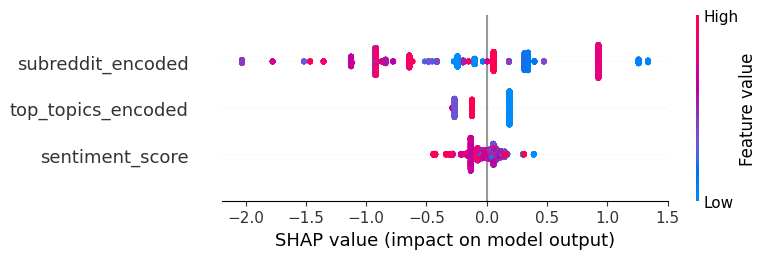

In [15]:
import shap

# Load the data
data = pd.read_csv(r'C:\Users\vidha\Downloads\normalized_data.csv')

# Split the dataset into features (X) and target variable (y)
X_numeric = data[['top_topics_encoded', 'subreddit_encoded', 'sentiment_score']]
y = data['controversiality']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# Define XGBoost pipeline without the ColumnTransformer
xg_boost_model = Pipeline([
    ('classifier', XGBClassifier(scale_pos_weight=1.5, reg_alpha=0.01, reg_lambda=0.01))
])

# Hyperparameter tuning for XGBoost
xg_boost_params = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__min_child_weight': [1, 3, 5],
    'classifier__gamma': [0, 0.1, 0.5],
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__reg_alpha': [0.001, 0.01, 0.1, 1],
    'classifier__reg_lambda': [0.001, 0.01, 0.1, 1],
    'classifier__scale_pos_weight': [1, 1.5, 2]
}

xg_boost_random_search = RandomizedSearchCV(xg_boost_model, xg_boost_params, cv=3, scoring='accuracy', n_jobs=1, n_iter=10, random_state=42)
xg_boost_random_search.fit(X_train, y_train)

print("Best XGBoost Hyperparameters:", xg_boost_random_search.best_params_)
print("Best XGBoost Accuracy:", xg_boost_random_search.best_score_)

# Fit the models with the best hyperparameters
xg_boost_model.set_params(**xg_boost_random_search.best_params_)
xg_boost_model.fit(X_train, y_train)

# Perform cross-validation to assess model performance
xg_boost_cv_scores = cross_val_score(xg_boost_model, X_numeric, y, cv=3, scoring='accuracy', n_jobs=1)

print("XGBoost Cross-Validation Scores:", xg_boost_cv_scores)
print("XGBoost Cross-Validation Mean Accuracy:", xg_boost_cv_scores.mean())

# Calculate accuracy on test set
y_pred = xg_boost_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("XGBoost Test Accuracy:", accuracy)

# SHAP Explainer
explainer = shap.Explainer(xg_boost_random_search.best_estimator_.named_steps['classifier'])
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)

# Individual explanations
# Choose a random instance for explanation
instance_idx = 0
instance_text = X_test.iloc[instance_idx]

# Explain prediction using SHAP
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[instance_idx], X_test.iloc[instance_idx])

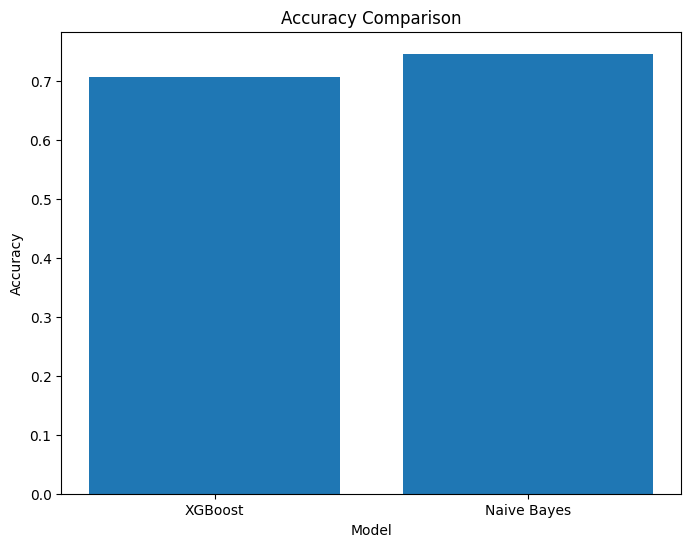

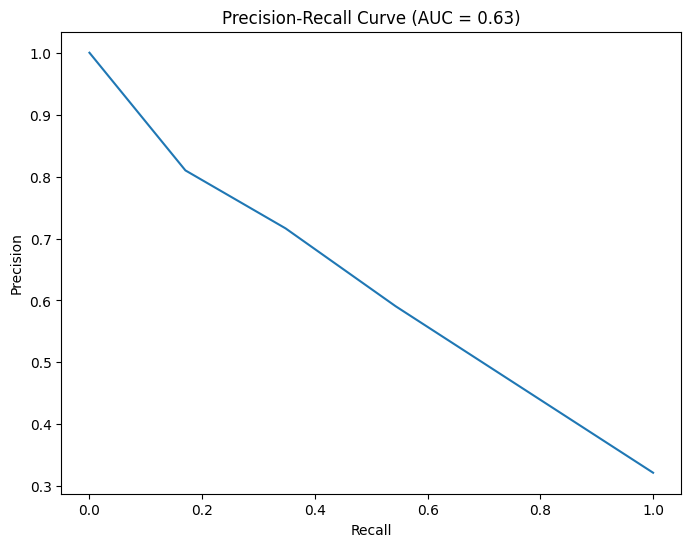

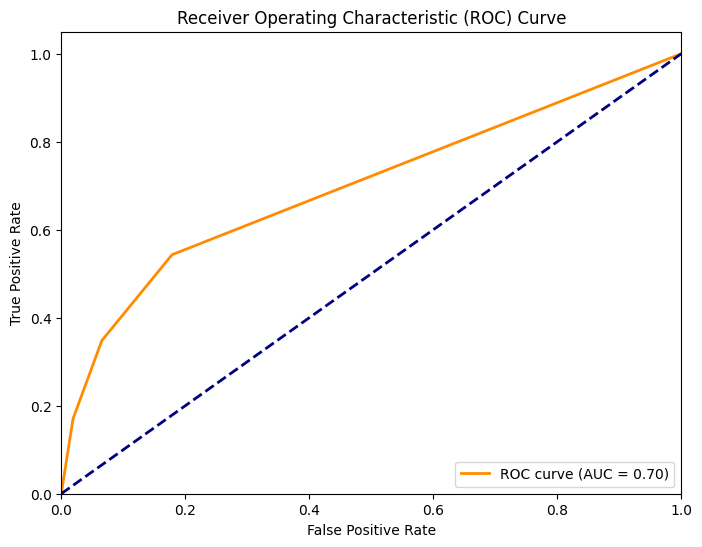

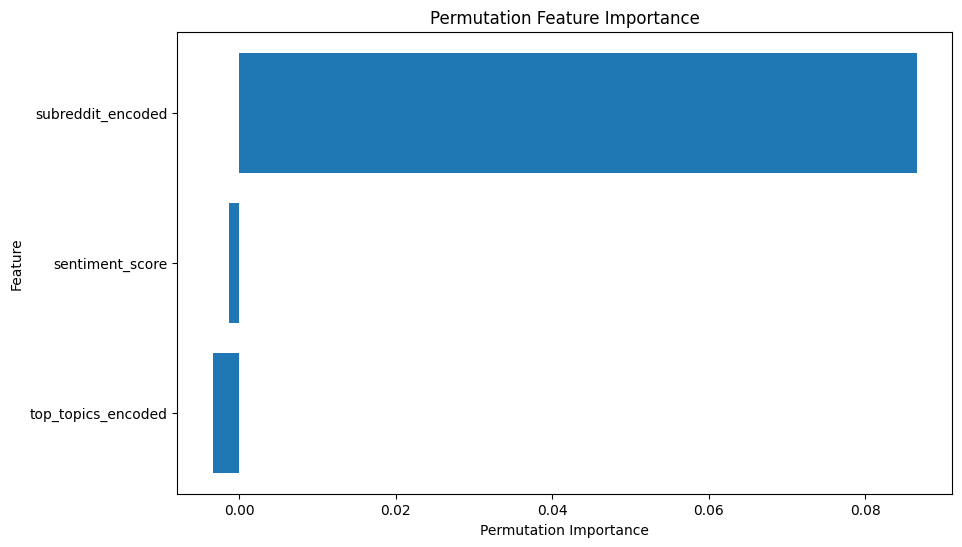

Top positive words: ['putin', 'say', 'ru', 'war', 'ua', 'ukrainian', 'pov', 'russia', 'russian', 'ukrain']
Top negative words: ['get', 'would', 'say', 'war', 'drone', 'putin', 'ukrainian', 'russia', 'ukrain', 'russian']


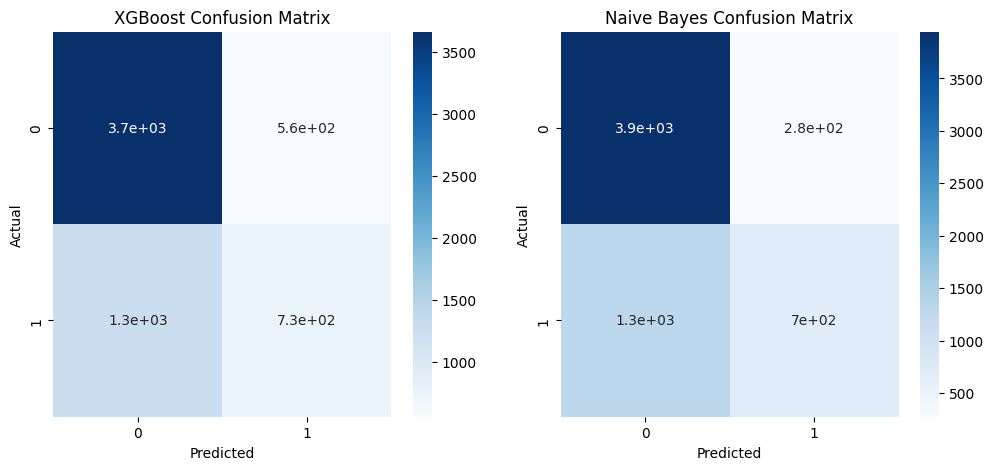

XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.87      0.80      4221
         1.0       0.57      0.37      0.44      2003

    accuracy                           0.71      6224
   macro avg       0.65      0.62      0.62      6224
weighted avg       0.69      0.71      0.69      6224


Naive Bayes Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.93      0.83      4221
         1.0       0.72      0.35      0.47      2003

    accuracy                           0.75      6224
   macro avg       0.73      0.64      0.65      6224
weighted avg       0.74      0.75      0.72      6224



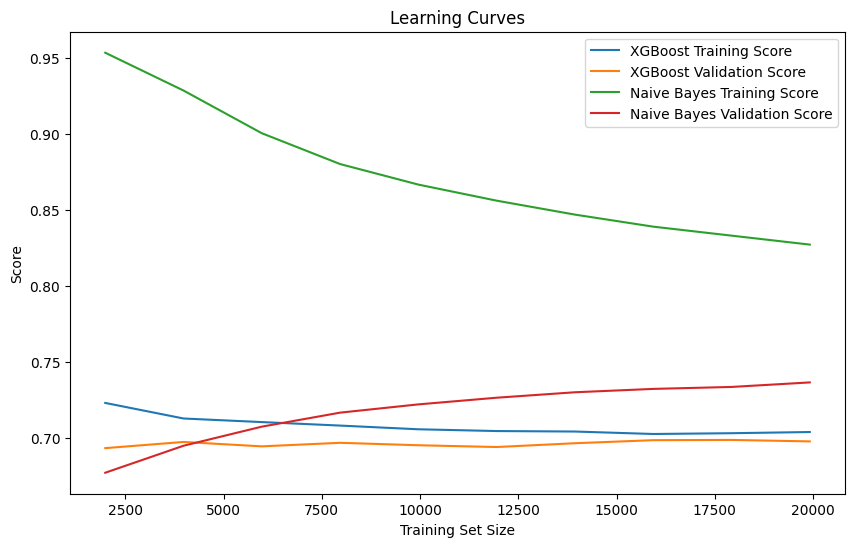

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report


# Plot accuracy comparison
plt.figure(figsize=(8, 6))
plt.bar(['XGBoost', 'Naive Bayes'], [xg_boost_accuracy, naive_bayes_accuracy])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.show()

# Plot precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, weighted_avg_preds)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve (AUC = {pr_auc:.2f})')
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, weighted_avg_preds)
roc_auc = roc_auc_score(y_test, weighted_avg_preds)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Compute permutation importances
perm_importance = permutation_importance(xg_boost_model, X_numeric_test, y_test, n_repeats=10, random_state=42)

# Get feature names
feature_names = X_numeric_train.columns

# Plot permutation importances
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance')
plt.show()

# Get Naive Bayes feature log probabilities
feature_log_prob = naive_bayes_model.named_steps['classifier'].feature_log_prob_

# Get top words for each class
num_top_words = 10
top_positive_words = [text_feature_names[idx] for idx in np.argsort(feature_log_prob[1])[-num_top_words:]]
top_negative_words = [text_feature_names[idx] for idx in np.argsort(feature_log_prob[0])[-num_top_words:]]

print("Top positive words:", top_positive_words)
print("Top negative words:", top_negative_words)

# Compute confusion matrices for both models
xg_boost_cm = confusion_matrix(y_test, xg_boost_preds_val)
naive_bayes_cm = confusion_matrix(y_test, naive_bayes_preds_val)

# Plot confusion matrices side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(xg_boost_cm, annot=True, cmap='Blues', ax=ax1)
ax1.set_title('XGBoost Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

sns.heatmap(naive_bayes_cm, annot=True, cmap='Blues', ax=ax2)
ax2.set_title('Naive Bayes Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.show()

# Generate classification reports for both models
xg_boost_report = classification_report(y_test, xg_boost_preds_val)
naive_bayes_report = classification_report(y_test, naive_bayes_preds_val)

print("XGBoost Classification Report:")
print(xg_boost_report)
print("\nNaive Bayes Classification Report:")
print(naive_bayes_report)

# Generate learning curves for both models
xg_boost_train_sizes, xg_boost_train_scores, xg_boost_val_scores = learning_curve(xg_boost_model, X_numeric_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
naive_bayes_train_sizes, naive_bayes_train_scores, naive_bayes_val_scores = learning_curve(naive_bayes_model, X_text_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(xg_boost_train_sizes, np.mean(xg_boost_train_scores, axis=1), label='XGBoost Training Score')
plt.plot(xg_boost_train_sizes, np.mean(xg_boost_val_scores, axis=1), label='XGBoost Validation Score')
plt.plot(naive_bayes_train_sizes, np.mean(naive_bayes_train_scores, axis=1), label='Naive Bayes Training Score')
plt.plot(naive_bayes_train_sizes, np.mean(naive_bayes_val_scores, axis=1), label='Naive Bayes Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend()
plt.show()

